In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import pickle
plt.style.use('../aslak.mplstyle')

In [23]:
#setting physcial constants
sec_per_year = 365.25 * 24 * 60 * 60
sec_per_month = sec_per_year/ 12
mon_year = 12 * 19
rhoi = 900  # kg_is/m3
ocean_density = 1028 #kg_ocean/m3
A_ocean = 3.625 *1e8 # area of the ocean in m2
n = 3
R = 8.31446261815324  # J/mol/K
g = 9.82
N = 50
fs = 5.7 * 1e-23
tau_0 = 1e5 # pa
total_regional_volume = 18773.51273532086 # km3

In [24]:
Precip_Scenario_dict = {
    'ssp126' :  '../Cmip6_data/Model_mean/precip/icmip6_pr_mon_modmean_ssp126_-176.13--126E_52.-69.5N_firstyear-lastyear_n_su.dat.txt',
    'ssp245' :  '../Cmip6_data/Model_mean/precip/icmip6_pr_mon_modmean_ssp245_-176.13--126E_52-69.5N_firstyear-lastyear_n_su.dat.txt',
    'ssp370' :  '../Cmip6_data/Model_mean/precip/icmip6_pr_mon_modmean_ssp370_-176.13--126E_52-69.5N_firstyear-lastyear_n_su.dat.txt',
    'ssp585' :  '../Cmip6_data/Model_mean/precip/icmip6_pr_mon_modmean_ssp585_-176.13--126E_52-69.5N_firstyear-lastyear_n_su.dat.txt',
}
Tas_Scenario_dict = {
    'ssp126' :  '../Cmip6_data/Model_mean/Tas/icmip6_tas_mon_modmean_ssp126_-176.13--126E_52-69.5N_firstyear-lastyear_n.dat.txt',
    'ssp245' :  '../Cmip6_data/Model_mean/Tas/icmip6_tas_mon_modmean_ssp245_-176.13--126E_52-69.5N_firstyear-lastyear_n.dat.txt',
    'ssp370' :  '../Cmip6_data/Model_mean/Tas/icmip6_tas_mon_modmean_ssp370_-176.13--126E_52-69.5N_firstyear-lastyear_n.dat.txt',
    'ssp585' :  '../Cmip6_data/Model_mean/Tas/icmip6_tas_mon_modmean_ssp585_-176.13--126E_52-69.5N_firstyear-lastyear_n.dat.txt',
}


# Precip_Scenario_dict = {
#     'ssp126' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp126_-176-.126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
#     'ssp245' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp245_-176--126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
#     'ssp370' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp370_0-360E_-90-90N_firstyear-lastyear_n_su_000.dat.txt',
#     'ssp585' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp585_-176--126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
# }
# Tas_Scenario_dict = {
#     'ssp126' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp126_-176--127E_52-69N_firstyear-lastyear_n_000.dat.txt',
#     'ssp245' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp245_-176--127E_52-69N_firstyear-lastyear_n_002.dat.txt',
#     'ssp370' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp370_-176--126E_52-69N_firstyear-lastyear_n_000.dat.txt',
#     'ssp585' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp585_-176--126E_52-69N_firstyear-lastyear_n_000.dat.txt',
# }

climate_hist_dict = {
 '1851-1870_hist' : [1851-1850, 1870-1850],
 '1901-1920_hist' : [1901-1850, 1920-1850],
 '1951-1970_hist' : [1951-1850, 1970-1850],
 '1995-2014_hist' : [1995-1850, 2014-1850],
 '2021-2040_hist' : [2021-1850, 2040-1850],
 '2041-2060_hist' : [2041-1850, 2060-1850],
 '2061-2080_hist' : [2061-1850, 2080-1850],
 '2081-2100_hist' : [2081-1850, 2100-1850],
}

def load_andprocess(scenario,period):
    """
    Load, process, and combine precipitation and temperature scenario data for a specified
    climate period. This function retrieves data paths based on the provided scenario, loads
    the data, processes it to match the given period, and converts temperatures from Kelvin
    to Celsius.

    :param scenario: The name of the climate scenario to load precipitation and temperature
        data for.
    :type scenario: str
    :param period: The name of the climate period defining the range of data to process.
    :type period: str
    :return: A combined numpy array with columns representing time, cropped precipitation,
        and cropped temperature (in Celsius), cal has indices [mean_temp, mean Precip].
    :rtype: numpy.ndarray
    """

    locp = Precip_Scenario_dict[scenario]
    locT = Tas_Scenario_dict[scenario]
    datp = np.loadtxt(locp, encoding='UTF-8')
    datT = np.loadtxt(locT, encoding='UTF-8')
    period = climate_hist_dict[period]
    # time = dat[period[0]:period[1],0].reshape(-1, 1)
    time = np.linspace(0, 19, num = 19*12)
    Mean_Temperature = np.mean(datT[136:155,1:].reshape(-1, 1))+0.69-273.15
    Mean_Precipitation = np.mean(datp[136:155,1:].reshape(-1, 1))
    croppedPrecip = np.concatenate(datp[period[0]:period[1],1:].reshape(-1, 1))
    croppedTas = np.concatenate(datT[period[0]:period[1],1:].reshape(-1, 1)) - 273.15
    out = np.column_stack((time, croppedPrecip, croppedTas))
    cal = np.array([Mean_Temperature, Mean_Precipitation])
    return out, cal
def get_temps(periods, scenario):
    temp_array = []
    for i in periods:
        out, tm = load_andprocess(scenario, i)
        temp_array.append(out[:, 2].mean())
    return temp_array

def get_steady_state_vol(Data):
    Steady_vols = []
    for i in range(len(Data)):
        vol = np.mean(Data[i][-2*mon_year:])
        Steady_vols.append(Data[i][-1])
    return np.asarray(Steady_vols)

periods = ['1995-2014_hist','2021-2040_hist', '2041-2060_hist', '2061-2080_hist', '2081-2100_hist']
# periods = ['1995-2014_hist']
# steady_volume = np.array([SLE_dict[i][1].sum() for i in periods])*270*1e-9
temps = get_temps(periods, 'ssp126')
Alaska = pd.read_csv('../Rgi/RGI2000-v7-C- Alaska/RGI2000-v7.0-G-01_alaska-attributes.csv')
glacier = Alaska.iloc[220]


In [25]:
glacier = Alaska.iloc[1807]
print(f'volume{0.067*(glacier['area_km2'])**1.23:.2f}')
print(f'mean elevation {glacier.zmean_m:.2f}')
print(f'min elevation {glacier.zmin_m:.2f}')
print(f'max elevation {glacier.zmax_m:.2f}')

volume33.98
mean elevation 1484.46
min elevation 165.04
max elevation 2256.81


In [26]:
Alaska.area_km2.sum()
mask = Alaska.area_km2 < 2.5
big_glaciers = Alaska[mask]


In [27]:
glacier

rgi_id        RGI2000-v7.0-G-01-01808
o1region                            1
o2region                        01-02
glims_id               G207124E60889N
anlys_id                       395483
subm_id                           624
src_date          2010-09-12T00:00:00
cenlon                    -152.871488
cenlat                      60.928074
utm_zone                            5
area_km2                   158.239655
primeclass                          0
conn_lvl                            0
surge_type                          3
term_type                           9
glac_name             Tanaina Glacier
is_rgi6                             1
termlon                   -152.726557
termlat                     60.821591
zmin_m                      165.04279
zmax_m                      2256.8137
zmed_m                      1545.4797
zmean_m                      1484.456
slope_deg                    10.74053
aspect_deg                  140.23915
aspect_sec                          4
dem_source  

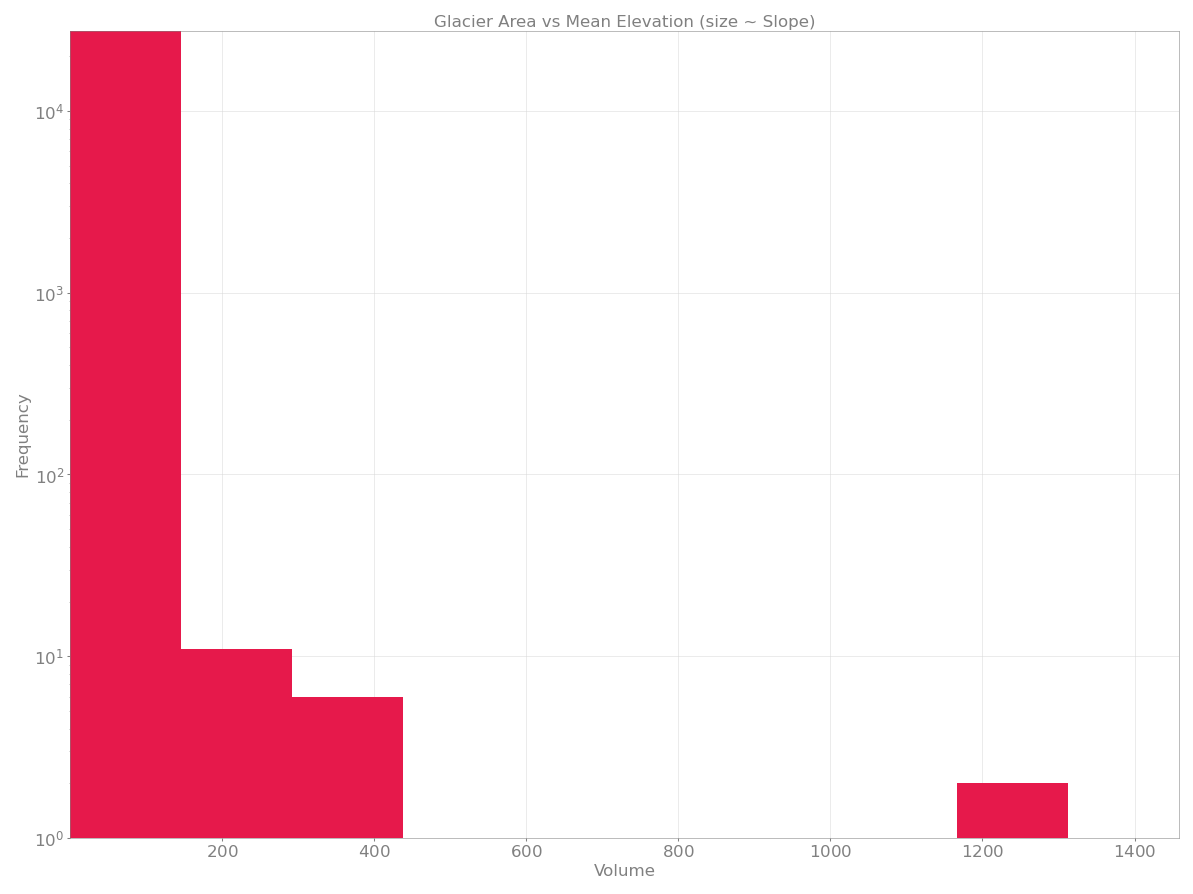

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist( 0.067*(Alaska['area_km2'])**1.23, log=True)
plt.title('Glacier Area vs Mean Elevation (size ~ Slope)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/3817199010.py:3: SyntaxWarning: invalid escape sequence '\m'
  ax[0,0].hist(Alaska.zmin_m, label = f'$\mu$ {np.mean(Alaska.zmin_m):.1f}')
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/3817199010.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax[0,1].hist(Alaska.zmean_m, label = f'$\mu$ {np.mean(Alaska.zmean_m):.1f}' )
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/3817199010.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax[1,0].hist(Alaska.zmax_m, label = f'$\mu$ {np.mean(Alask

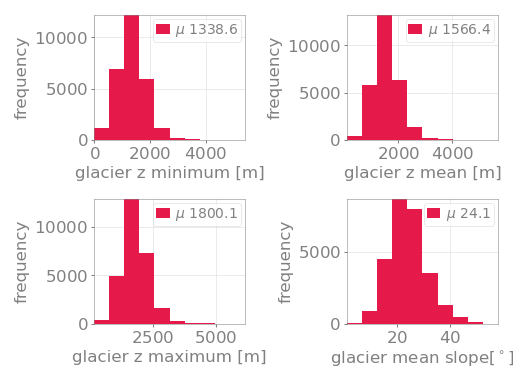

In [29]:
fig,ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].hist(Alaska.zmin_m, label = f'$\mu$ {np.mean(Alaska.zmin_m):.1f}')
ax[0,0].set_xlabel('glacier z minimum [m]')
ax[0,0].set_ylabel('frequency')
ax[0,0].legend()
ax[0,1].hist(Alaska.zmean_m, label = f'$\mu$ {np.mean(Alaska.zmean_m):.1f}' )
ax[0,1].set_xlabel('glacier z mean [m]')
ax[0,1].set_ylabel('frequency')
ax[0,1].legend()
ax[1,0].hist(Alaska.zmax_m, label = f'$\mu$ {np.mean(Alaska.zmax_m):.1f}' )
ax[1,0].set_xlabel('glacier z maximum [m]')
ax[1,0].set_ylabel('frequency')
ax[1,0].legend()
ax[1,1].hist(Alaska.slope_deg, label = f'$\mu$ {np.mean(Alaska.slope_deg):.1f}')
ax[1,1].set_xlabel(r'glacier mean slope[$^\circ$]')
ax[1,1].set_ylabel('frequency')
ax[1,1].legend()
plt.tight_layout()

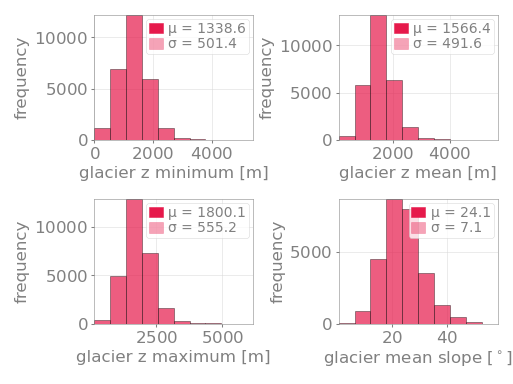

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, ax = plt.subplots(nrows=2, ncols=2)

fields = ['zmin_m', 'zmean_m', 'zmax_m', 'slope_deg']
xlabels = [
    'glacier z minimum [m]',
    'glacier z mean [m]',
    'glacier z maximum [m]',
    r'glacier mean slope [$^\circ$]',
]

for axis, field, xlabel in zip(ax.flat, fields, xlabels):
    data = Alaska[field]
    mu = data.mean()
    sigma = data.std()
    axis.hist(data,  edgecolor='k', alpha=0.7)
    axis.set_xlabel(xlabel)
    axis.set_ylabel('frequency')

    patch_mean = mpatches.Patch(color='C0', label=f'μ = {mu:.1f}')
    patch_std = mpatches.Patch(color='C0', alpha=0.4, label=f'σ = {sigma:.1f}')
    axis.legend(handles=[patch_mean, patch_std])
plt.tight_layout(w_pad=0.1)
plt.show()

In [31]:
#Loading ssp 126 data
# with open(f'Data_dict_ssp126_2081_2100_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_126_2081_2100 = pickle.load(f)
# with open(f'Data_dict_ssp126_2021-2040_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_126_2021_2040 = pickle.load(f)
# with open(f'Data_dict_ssp126_1995-2014_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_126_1995_2014 = pickle.load(f)
# with open(f'Data_dict_ssp126_2041-2060_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_126_2041_2060 = pickle.load(f)
#
# #Loading ssp 245 data
# with open(f'Data_dict_ssp245_2081_2100_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_245_2081_2100 = pickle.load(f)
# with open(f'Data_dict_ssp245_2021-2040_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_245_2021_2040 = pickle.load(f)
# with open(f'Data_dict_ssp245_1995-2014_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_245_1995_2014 = pickle.load(f)
# with open(f'Data_dict_ssp245_2041-2060_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_245_2041_2060 = pickle.load(f)
#
# #Loading ssp 370 data
# with open(f'Data_dict_ssp370_2081_2100_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_370_2081_2100 = pickle.load(f)
# with open(f'Data_dict_ssp370_2021-2040_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_370_2021_2040 = pickle.load(f)
# with open(f'Data_dict_ssp370_1995-2014_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_370_1995_2014 = pickle.load(f)
# with open(f'Data_dict_ssp370_2041-2060_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_370_2041_2060 = pickle.load(f)
#
# #Loading ssp 585 data
# with open(f'Data_dict_ssp585_2081_2100_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_585_2081_2100 = pickle.load(f)
# with open(f'Data_dict_ssp585_2021-2040_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_585_2021_2040 = pickle.load(f)
# with open(f'Data_dict_ssp585_1995-2014_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_585_1995_2014 = pickle.load(f)
# with open(f'Data_dict_ssp585_2041-2060_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     Data_585_2041_2060 = pickle.load(f)

# long_glaciers_mask = Alaska.lmax_m > 1e4
# long_glaciers = Alaska.lmax_m[long_glaciers_mask]
# New_vols_1995_random_245 = get_steady_state_vol(Data_245_random['1995-2014_hist']['Glacier volume'][:]) * 1e-9
# New_vols_2021_random_245 = get_steady_state_vol(Data_245_random['2021-2040_hist']['Glacier volume'][:]) * 1e-9
# New_vols_2041_random_245 = get_steady_state_vol(Data_245_random['2041-2060_hist']['Glacier volume'][:]) * 1e-9
# New_vols_2061_random_245 = get_steady_state_vol(Data_245_random['2061-2080_hist']['Glacier volume'][:]) * 1e-9
# New_vols_2081_random_245 = get_steady_state_vol(Data_245_random['2081-2100_hist']['Glacier volume'][:]) * 1e-9
# init_vols = np.asarray(Data_245_random['1995-2014_hist']['Initial volume'][:])*1e-9
# Indeces = Data_245_random['1995-2014_hist']['Glacier index']
# Volume = 0.067 * (Alaska.area_km2.iloc[Indeces]) ** 1.23
len(Data_126_2081_2100['2081-2100_hist']['Glacier volume'][:])

NameError: name 'Data_126_2081_2100' is not defined

In [32]:
with open('SimulationData/Data_dict_ssp126_2081-2100_histalaska_PDD_Glaciers_precip_offset_test.pkl', 'rb') as f:
    offset_data_126 = pickle.load(f)
with open('SimulationData/Data_dict_ssp245_2081-2100_histalaska_PDD_Glaciers_precip_offset_test.pkl', 'rb') as f:
    offset_data_245 = pickle.load(f)
with open('SimulationData/Data_dict_ssp370_2081-2100_histalaska_PDD_Glaciers_precip_offset_test.pkl', 'rb') as f:
    offset_data_370 = pickle.load(f)
with open('SimulationData/Data_dict_ssp585_2081-2100_histalaska_PDD_Glaciers_precip_offset_test.pkl', 'rb') as f:
    offset_data_585 = pickle.load(f)


In [34]:
offset_data_245.keys()
init_offset_vol = np.asarray(offset_data_245['2081-2100_hist']['Initial volume'][:]).sum()
glacier_volume_offset_95 = get_steady_state_vol(offset_data_245['1995-2014_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_offset_21 = get_steady_state_vol(offset_data_245['2021-2040_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_offset_41 = get_steady_state_vol(offset_data_245['2041-2060_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_offset_61 = get_steady_state_vol(offset_data_245['2061-2080_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_offset_81 = get_steady_state_vol(offset_data_245['2081-2100_hist']['Glacier volume'][:][1:]).sum()

# glacier_volume_offset_/init_offset_vol

In [35]:
mask = np.where(get_steady_state_vol(offset_data_126['2081-2100_hist']['Glacier volume'][:][1:]) == np.max(
    get_steady_state_vol(offset_data_126['2081-2100_hist']['Glacier volume'][:][1:])))[0][0]
mask

1593

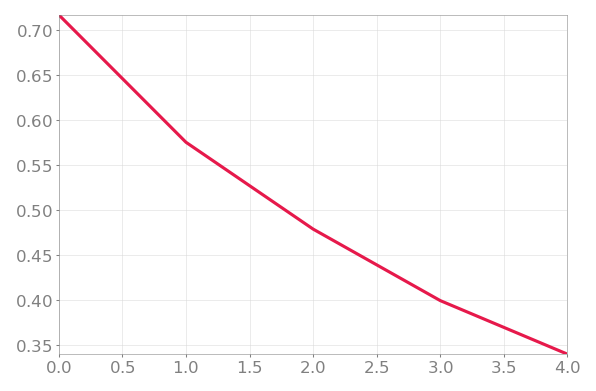

In [36]:
times = np.arange(0,5, 1)
vols_list = np.asarray([glacier_volume_offset_95, glacier_volume_offset_21, glacier_volume_offset_41, glacier_volume_offset_61, glacier_volume_offset_81])/init_offset_vol
plt.plot(times, vols_list)

# Single glacier plots

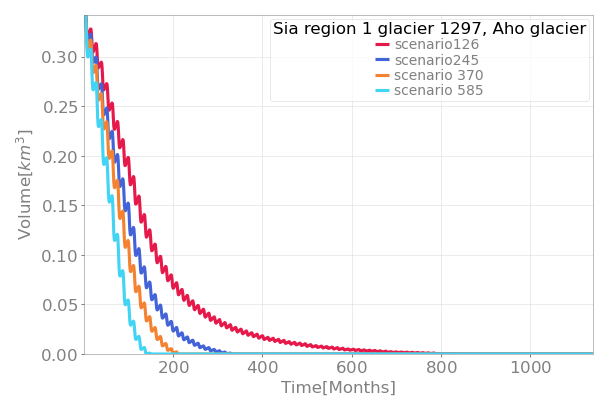

In [37]:
index = 1297

glacier_volume_126 = offset_data_126['2081-2100_hist']['Glacier volume'][index][1:]*1e-9
glacier_volume_245 = offset_data_245['2081-2100_hist']['Glacier volume'][index][1:]*1e-9
glacier_volume_370 = offset_data_370['2081-2100_hist']['Glacier volume'][index][1:]*1e-9
glacier_volume_585 = offset_data_585['2081-2100_hist']['Glacier volume'][index][1:]*1e-9

glacier_years_126 = offset_data_126['2081-2100_hist']['Years runtime'][index][1:]
glacier_years_245 = offset_data_245['2081-2100_hist']['Years runtime'][index][1:]
glacier_years_370 = offset_data_370['2081-2100_hist']['Years runtime'][index][1:]
glacier_years_585 = offset_data_585['2081-2100_hist']['Years runtime'][index][1:]
plt.figure()

plt.plot(glacier_years_126,glacier_volume_126, label = 'scenario126')
plt.plot(glacier_years_245,glacier_volume_245, label = 'scenario245')
plt.plot(glacier_years_370,glacier_volume_370, label = 'scenario 370')
plt.plot(glacier_years_585,glacier_volume_585, label = 'scenario 585')
plt.xlabel('Time[Months]')
plt.ylabel(r'Volume[$km^3$]')
plt.legend(title = f'Sia region 1 glacier {index}, Aho glacier')
# glacier = Alaska.iloc[index]
# print(glacier.area_km2, glacier.zmax_m)
# print(Data_126_2081_2100['2081-2100_hist']['Glacier index'][index])

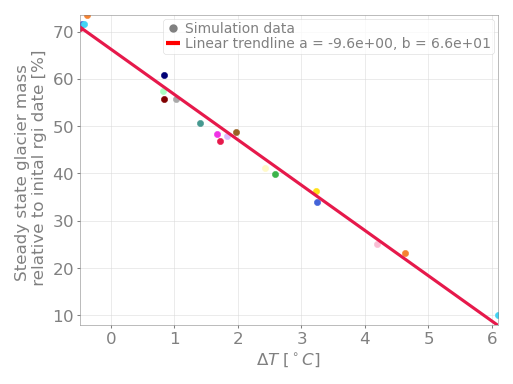

In [52]:
initial_glacier_volume_steady = np.asarray(offset_data_126['2081-2100_hist']['Initial volume'][:]).sum()
glacier_volume_steady_126_81 = get_steady_state_vol(offset_data_126['2081-2100_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_245_81 = get_steady_state_vol(offset_data_245['2081-2100_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_370_81 = get_steady_state_vol(offset_data_370['2081-2100_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_585_81 = get_steady_state_vol(offset_data_585['2081-2100_hist']['Glacier volume'][:][1:]).sum()

glacier_volume_steady_126_95 = get_steady_state_vol(offset_data_126['1995-2014_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_245_95 = get_steady_state_vol(offset_data_245['1995-2014_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_370_95 = get_steady_state_vol(offset_data_370['1995-2014_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_585_95 = get_steady_state_vol(offset_data_585['1995-2014_hist']['Glacier volume'][:][1:]).sum()

glacier_volume_steady_126_21 = get_steady_state_vol(offset_data_126['2021-2040_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_245_21 = get_steady_state_vol(offset_data_245['2021-2040_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_370_21 = get_steady_state_vol(offset_data_370['2021-2040_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_585_21 = get_steady_state_vol(offset_data_585['2021-2040_hist']['Glacier volume'][:][1:]).sum()

glacier_volume_steady_126_41 = get_steady_state_vol(offset_data_126['2041-2060_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_245_41 = get_steady_state_vol(offset_data_245['2041-2060_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_370_41 = get_steady_state_vol(offset_data_370['2041-2060_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_585_41 = get_steady_state_vol(offset_data_585['2041-2060_hist']['Glacier volume'][:][1:]).sum()
#
glacier_volume_steady_126_61 = get_steady_state_vol(offset_data_126['2061-2080_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_245_61 = get_steady_state_vol(offset_data_245['2061-2080_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_370_61 = get_steady_state_vol(offset_data_370['2061-2080_hist']['Glacier volume'][:][1:]).sum()
glacier_volume_steady_585_61 = get_steady_state_vol(offset_data_585['2061-2080_hist']['Glacier volume'][:][1:]).sum()

steady_state_volumes = np.array(
    [glacier_volume_steady_126_81, glacier_volume_steady_245_81, glacier_volume_steady_370_81,
     glacier_volume_steady_585_81]) * 1e-9
steady_state_volumes_95 = np.array(
    [glacier_volume_steady_126_95, glacier_volume_steady_245_95, glacier_volume_steady_370_95,
     glacier_volume_steady_585_95]) * 1e-9
steady_state_volumes_21 = np.array(
    [glacier_volume_steady_126_21, glacier_volume_steady_245_21, glacier_volume_steady_370_21,
     glacier_volume_steady_585_21]) * 1e-9
steady_state_volumes_41 = np.array(
    [glacier_volume_steady_126_41, glacier_volume_steady_245_41, glacier_volume_steady_370_41,
     glacier_volume_steady_585_41]) * 1e-9
steady_state_volumes_61 = np.array(
    [glacier_volume_steady_126_61, glacier_volume_steady_245_61, glacier_volume_steady_370_61,
     glacier_volume_steady_585_61]) * 1e-9

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

temps81 = [get_temps(['2081-2100_hist'], scenario) for scenario in scenarios]
temps61 = [get_temps(['2061-2080_hist'], scenario) for scenario in scenarios]
temps41 = [get_temps(['2041-2060_hist'], scenario) for scenario in scenarios]
temps21 = [get_temps(['2021-2040_hist'], scenario) for scenario in scenarios]
temps95 = [get_temps(['1995-2014_hist'], scenario) for scenario in scenarios]

temp_equl_plot = plt.figure()
plt.scatter(temps81[0], steady_state_volumes[0]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps81[1], steady_state_volumes[1]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps81[2], steady_state_volumes[2]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps81[3], steady_state_volumes[3]/(initial_glacier_volume_steady*1e-9)*100)

plt.scatter(temps61[0], steady_state_volumes_61[0]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps61[1], steady_state_volumes_61[1]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps61[2], steady_state_volumes_61[2]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps61[3], steady_state_volumes_61[3]/(initial_glacier_volume_steady*1e-9)*100)
#
plt.scatter(temps41[0], steady_state_volumes_41[0]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps41[1], steady_state_volumes_41[1]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps41[2], steady_state_volumes_41[2]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps41[3], steady_state_volumes_41[3]/(initial_glacier_volume_steady*1e-9)*100)

plt.scatter(temps21[0], steady_state_volumes_21[0]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps21[1], steady_state_volumes_21[1]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps21[2], steady_state_volumes_21[2]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps21[3], steady_state_volumes_21[3]/(initial_glacier_volume_steady*1e-9)*100)

plt.scatter(temps95[0], steady_state_volumes_95[0]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps95[1], steady_state_volumes_95[1]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps95[2], steady_state_volumes_95[2]/(initial_glacier_volume_steady*1e-9)*100)
plt.scatter(temps95[3], steady_state_volumes_95[3]/(initial_glacier_volume_steady*1e-9)*100)

#until the sim is finished

    # steady_state_volumes_61/(initial_glacier_volume_steady*1e-9),
    #
    # temps61,
#Making a trendline (quadratic)
volumes = np.concatenate([
    steady_state_volumes_95/(initial_glacier_volume_steady*1e-9),
    steady_state_volumes_21/(initial_glacier_volume_steady*1e-9),
    steady_state_volumes_41/(initial_glacier_volume_steady*1e-9),
    steady_state_volumes/(initial_glacier_volume_steady*1e-9)
]).astype(float)*100

temps = np.concatenate([
    temps95,
    temps21,
    temps41,
    temps81
]).astype(float)

def linfit(x, a, b):
    return a* x +b


temps_sorted  = np.array(sorted(temps)).reshape(-1)
volumes_sorted = np.array(sorted(volumes, reverse=True)).reshape(-1)
popt, pcov = curve_fit(linfit, xdata=temps_sorted, ydata=volumes_sorted, method='lm')
quadratic_trend = linfit(temps_sorted,*popt)
plt.plot(temps_sorted, quadratic_trend)
plt.xlabel(r'$\Delta T$ [$ ^\circ C$]')
plt.ylabel('Steady state glacier mass \n relative to inital rgi date [%]')

scatter_proxy = Line2D([0], [0],
                       linestyle="",
                       marker="o",
                       color="gray",
                       label="Simulation data")

line_proxy    = Line2D([0], [0],
                       linestyle="-",
                       color="red",
                       lw=2,
                       label=f"Linear trendline a = {popt[0]:.1e}, b = {popt[1]:.1e}")

plt.legend(handles=[scatter_proxy, line_proxy])
plt.tight_layout()




## make a equilibration graph


In [53]:
glacier_volume_126_81 = offset_data_126['2081-2100_hist']['Glacier volume'][:][1:]
glacier_volume_245_81 = offset_data_245['2081-2100_hist']['Glacier volume'][:][1:]
glacier_volume_370_81 = offset_data_370['2081-2100_hist']['Glacier volume'][:][1:]
glacier_volume_585_81 = offset_data_585['2081-2100_hist']['Glacier volume'][:][1:]

glacier_volume_126_41 = offset_data_126['2041-2060_hist']['Glacier volume'][:][1:]
glacier_volume_245_41 = offset_data_245['2041-2060_hist']['Glacier volume'][:][1:]
glacier_volume_370_41 = offset_data_370['2041-2060_hist']['Glacier volume'][:][1:]
glacier_volume_585_41 = offset_data_585['2041-2060_hist']['Glacier volume'][:][1:]

glacier_volume_126_95 = offset_data_126['1995-2014_hist']['Glacier volume'][:][1:]
glacier_volume_245_95 = offset_data_245['1995-2014_hist']['Glacier volume'][:][1:]
glacier_volume_370_95 = offset_data_370['1995-2014_hist']['Glacier volume'][:][1:]
glacier_volume_585_95 = offset_data_585['1995-2014_hist']['Glacier volume'][:][1:]

glacier_volume_126_21 = offset_data_126['2021-2040_hist']['Glacier volume'][:][1:]
glacier_volume_245_21 = offset_data_245['2021-2040_hist']['Glacier volume'][:][1:]
glacier_volume_370_21 = offset_data_370['2021-2040_hist']['Glacier volume'][:][1:]
glacier_volume_585_21 = offset_data_585['2021-2040_hist']['Glacier volume'][:][1:]

In [54]:
def make_arrays_compatible(Data):
    total_list = []
    maxlength = 11852
    print(maxlength)
    for i in range(len(Data)):
        Length_to_be_added = maxlength - len(Data[i])
        tail = np.ones(Length_to_be_added) * Data[i][-1]
        newData = np.append(Data[i],tail)
        total_list.append(newData)
    return np.asarray(total_list)

In [55]:
lenlist =[len(i) for i in glacier_volume_126_81[:]]
mask = lenlist == 18240
lenlist[mask]

1141

In [61]:
initial_glacier_volume_steady = np.asarray(offset_data_126['2081-2100_hist']['Initial volume'][:]).sum()
Volume_scaling = 100/(initial_glacier_volume_steady*1e-9)

In [62]:
# maxlen = max([len(i) for i in glacier_volume_126_81])
maxlen = 11852

Vol_array81_126 = np.sum(make_arrays_compatible(glacier_volume_126_81), axis = 0)
Vol_array81_245 = np.sum(make_arrays_compatible(glacier_volume_245_81), axis = 0)
Vol_array81_370 = np.sum(make_arrays_compatible(glacier_volume_370_81), axis = 0)
Vol_array81_585 = np.sum(make_arrays_compatible(glacier_volume_585_81), axis = 0)

Vol_array41_126 = np.sum(make_arrays_compatible(glacier_volume_126_41), axis = 0)
Vol_array41_245 = np.sum(make_arrays_compatible(glacier_volume_245_41), axis = 0)
Vol_array41_370 = np.sum(make_arrays_compatible(glacier_volume_370_41), axis = 0)
Vol_array41_585 = np.sum(make_arrays_compatible(glacier_volume_585_41), axis = 0)

Vol_array21_126 = np.sum(make_arrays_compatible(glacier_volume_126_21), axis = 0)
Vol_array21_245 = np.sum(make_arrays_compatible(glacier_volume_245_21), axis = 0)
Vol_array21_370 = np.sum(make_arrays_compatible(glacier_volume_370_21), axis = 0)
Vol_array21_585 = np.sum(make_arrays_compatible(glacier_volume_585_21), axis = 0)

Vol_array95_126 = np.sum(make_arrays_compatible(glacier_volume_126_95), axis = 0)
Vol_array95_245 = np.sum(make_arrays_compatible(glacier_volume_245_95), axis = 0)
Vol_array95_370 = np.sum(make_arrays_compatible(glacier_volume_370_95), axis = 0)
Vol_array95_585 = np.sum(make_arrays_compatible(glacier_volume_585_95), axis = 0)


11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852
11852


In [63]:
Vol_arrays_81_sum = np.vstack([Vol_array81_126, Vol_array81_245, Vol_array81_370, Vol_array81_585])
Vol_arrays_21_sum = np.vstack([Vol_array21_126, Vol_array21_245, Vol_array21_370, Vol_array21_585])
Vol_arrays_41_sum = np.vstack([Vol_array41_126, Vol_array41_245, Vol_array41_370, Vol_array41_585])
Vol_arrays_95_sum = np.vstack([Vol_array95_126, Vol_array95_245, Vol_array95_370, Vol_array95_585])
total_sum_array = np.vstack([Vol_arrays_81_sum, Vol_arrays_21_sum, Vol_arrays_41_sum, Vol_arrays_95_sum], dtype = float)*Volume_scaling

np.savetxt('total_sum_array.csv', total_sum_array, delimiter = ',',)

<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/1210082353.py:26: SyntaxWarning: invalid escape sequence '\c'
  temp_patch_126 = mpatches.Patch(color='#FF0000', label=f'ssp126 [$-0.5-1.7 ^\circ C$]')
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/1210082353.py:27: SyntaxWarning: invalid escape sequence '\c'
  temp_patch_245 = mpatches.Patch(color='#33FF55', label=f'ssp245 [$-0.5-3.2 ^\circ C$]')
/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_16021/1210082353.py:28: SyntaxWarning: invalid escape sequence '\c'
  temp_patch_370 = mpatches.Pat

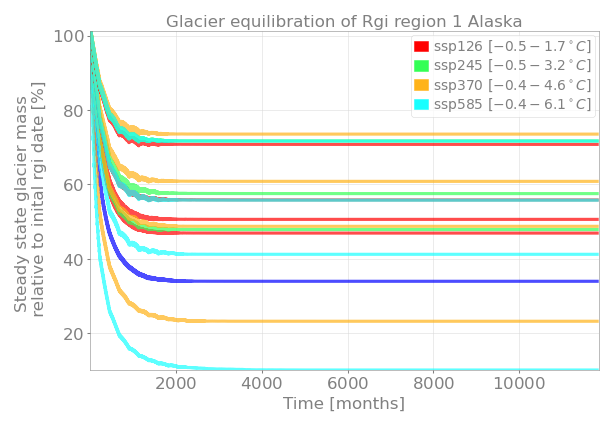

In [65]:
time_array = np.arange(0,maxlen, 1)
equl_plot = plt.figure()
plt.plot(time_array[1:], Vol_array81_126[1:]*1e-9* Volume_scaling, color = '#FF0000', alpha = 0.7)
plt.plot(time_array[1:], Vol_array81_245[1:]*1e-9* Volume_scaling, color = '#0000FF', alpha = 0.7)
plt.plot(time_array[1:], Vol_array81_370[1:]*1e-9* Volume_scaling, color = '#FFB319', alpha = 0.7)
plt.plot(time_array[1:], Vol_array81_585[1:]*1e-9* Volume_scaling, color = '#19FFFF', alpha = 0.7)

plt.plot(time_array[1:], Vol_array41_126[1:]*1e-9* Volume_scaling, color = '#FF0000', alpha = 0.7)
plt.plot(time_array[1:], Vol_array41_245[1:]*1e-9* Volume_scaling, color = '#33FF55', alpha = 0.7)
plt.plot(time_array[1:], Vol_array41_370[1:]*1e-9* Volume_scaling, color = '#FFB319', alpha = 0.7)
plt.plot(time_array[1:], Vol_array41_585[1:]*1e-9* Volume_scaling, color = '#19FFFF', alpha = 0.7)

plt.plot(time_array[1:], Vol_array21_126[1:]*1e-9* Volume_scaling, color = '#FF0000', alpha = 0.7)
plt.plot(time_array[1:], Vol_array21_245[1:]*1e-9* Volume_scaling, color = '#33FF55', alpha = 0.7)
plt.plot(time_array[1:], Vol_array21_370[1:]*1e-9* Volume_scaling, color = '#FFB319', alpha = 0.7)
plt.plot(time_array[1:], Vol_array21_585[1:]*1e-9* Volume_scaling, color = '#19FFFF', alpha = 0.7)

plt.plot(time_array[1:], Vol_array95_126[1:]*1e-9* Volume_scaling, color = '#FF0000', alpha = 0.7)
plt.plot(time_array[1:], Vol_array95_245[1:]*1e-9* Volume_scaling, color = '#33FF55', alpha = 0.7)
plt.plot(time_array[1:], Vol_array95_370[1:]*1e-9* Volume_scaling, color = '#FFB319', alpha = 0.7)
plt.plot(time_array[1:], Vol_array95_585[1:]*1e-9* Volume_scaling, color = '#19FFFF', alpha = 0.7)

plt.xlabel('Time [months]')
plt.ylabel('Steady state glacier mass \n relative to inital rgi date [%]')
plt.title('Glacier equilibration of Rgi region 1 Alaska')
temp_patch_126 = mpatches.Patch(color='#FF0000', label=f'ssp126 [$-0.5-1.7 ^\circ C$]')
temp_patch_245 = mpatches.Patch(color='#33FF55', label=f'ssp245 [$-0.5-3.2 ^\circ C$]')
temp_patch_370 = mpatches.Patch(color='#FFB319', label=f'ssp370 [$-0.4-4.6 ^\circ C$]')
temp_patch_585 = mpatches.Patch(color='#19FFFF', label=f'ssp585 [$-0.4-6.1 ^\circ C$]')

handl = [temp_patch_126,temp_patch_245, temp_patch_370, temp_patch_585]
plt.legend(handles = handl)


[[-0.4952324561403285],
 [-0.45237456140348675],
 [-0.38049912280699494],
 [-0.42715131578945165]]